In [1]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from utils import construct_confidence_interval

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit

In [2]:
%load_ext autoreload
%autoreload 2

### Generate the problem / prepare selected datasets

In [3]:
nrows = None
random_seed=43 #tri topora

In [4]:
def load_merged_dataset():
    """
    Function to load the adult income dataset
    
    Returns: X, y, protected_attribute
    """
    numerical_features_index = [0, 2, 4, 10, 11, 12]

    data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
    y_train = data_train.loc[:, data_train.columns[-1]]
    gender_train = data_train.loc[:, data_train.columns[9]]


    data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
    y_test = data_test.loc[:, data_train.columns[-1]]
    gender_test = data_test.loc[:, data_test.columns[9]]

    data = pd.concat((data_train, data_test))
    
    data.drop(data.columns.difference(numerical_features_index), axis=1, inplace=True)
    data = data.astype(np.float64)


    gender_train = gender_train.apply(lambda x: x.strip())
    
    data.drop_duplicates(inplace=True)
#     y_train = y_train.loc[data_train.index]
#     gender_train = gender_train.loc[data_train.index]

    #assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]
    
    binarizer = LabelBinarizer()
    y_train = binarizer.fit_transform(y_train).ravel()
    y_test = binarizer.fit_transform(y_test).ravel()

    gender_binarizer = LabelBinarizer()
    gender_binary_train = gender_binarizer.fit_transform(gender_train.values).ravel()
    gender_binary = gender_binarizer.fit_transform(gender_test.values).ravel()

    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    return data, np.concatenate((y_train, y_test)), np.concatenate((gender_binary_train, gender_binary))

In [5]:
#data, y_data, gender_all = load_merged_dataset()

In [6]:
#shuffle_splitter = ShuffleSplit(n_splits=10, test_size=0.4, random_state=random_seed)

In [7]:
# for train_index, test_index in shuffle_splitter.split(data):
#     data_train, data_test = data[train_index], data[test_index]
#     y_train, y_test = y_data[train_index], y_data[test_index]
#     gender_train, gender_test = gender_all[train_index], gender_all[test_index]
#     break

In [8]:
numerical_features_index = [0, 2, 4, 10, 11, 12]

data_train = pd.read_csv('../datasets/Adult income dataset/adult.data', nrows=nrows, header=None)
y_train = data_train.loc[:, data_train.columns[-1]]
gender_train = data_train.loc[:, data_train.columns[9]]


data_test = pd.read_csv('../datasets/Adult income dataset/adult.test', skiprows=1, header=None)
y_test = data_test.loc[:, data_train.columns[-1]]
gender_test = data_test.loc[:, data_test.columns[9]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_test.drop(data_test.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)
data_test = data_test.astype(np.float64)


gender_train = gender_train.apply(lambda x: x.strip())
gender_test = gender_test.apply(lambda x: x.strip())

In [9]:
data_train.drop_duplicates(inplace=True)
data_test.drop_duplicates(inplace=True)

y_train = y_train.loc[data_train.index]
y_test = y_test.loc[data_test.index]
gender_train = gender_train.loc[data_train.index]
gender_test = gender_test.loc[data_test.index]

assert data_train.shape[0] == y_train.shape[0] == gender_train.shape[0]

y_def_train = y_train
y_def_test = y_test

binarizer = LabelBinarizer()
y_train = binarizer.fit_transform(y_train).ravel()
y_test = binarizer.fit_transform(y_test).ravel()

gender_binarizer = LabelBinarizer()
gender_train = gender_binarizer.fit_transform(gender_train.values).ravel()
gender_test = gender_binarizer.fit_transform(gender_test.values).ravel()

scaler = StandardScaler()
data_train = scaler.fit_transform(data_train)
data_test = scaler.transform(data_test)

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter

from sklearn.model_selection import GridSearchCV

/home/grapefroot/datascience3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [11]:
# clf_base = RandomForestClassifier(class_weight='balanced')#random_state=random_seed)

# param_grid = {
#     'n_estimators': [10, 50, 100, 200, 500, 1000],
#     'max_depth': [None, 2, 3, 4, 5, 6],
#     'min_samples_split': [2, 3, 4, 5]
# }

In [12]:
# clf_base = GradientBoostingClassifier()

# param_grid = {
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
#     'n_estimators': [100, 200, 500, 1000],
#     'min_samples_split': [2, 3, 4, 5],
#     'max_depth':[None, 2, 3, 4, 5, 6]
# }

In [13]:
clf_base = LogisticRegression()
param_grid = {
    'penalty': ['l1', 'l2'],
    'C':[0.1, 0.2, 0.5, 1],
}

In [14]:
clf = GridSearchCV(clf_base, param_grid, scoring='f1', n_jobs=-1, verbose=1, refit=True)
clf.fit(data_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:    0.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.1, 0.2, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=1)

In [15]:
clf.best_estimator_

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [16]:
clf_predictions = clf.predict(data_test)

In [17]:
print(Counter(y_test))

print(Counter(clf_predictions))

Counter({0: 12390, 1: 3836})
Counter({0: 14068, 1: 2158})


In [18]:
print('Initial accuracy of classification: {}'.format(accuracy_score(y_test, clf_predictions)))

Initial accuracy of classification: 0.8133859238259583


In [19]:
negative_label = 0
positive_label = 1

In [20]:
male_entries_index = gender_train[gender_train == positive_label]
female_entries_index = gender_train[gender_train == negative_label]

male_entries_test_index = gender_test[gender_test == positive_label]
female_entries_test_index = gender_test[gender_test == negative_label]

In [21]:
n0 = data_train[gender_train == positive_label].shape[0]
n1 = data_train[gender_train == negative_label].shape[0]
n0_test = data_test[gender_test == positive_label].shape[0]
n1_test = data_test[gender_test == negative_label].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0
emperical_histogram_female = np.ones_like(female_entries_index) / n1

emperical_histogram_male_test = np.ones_like(male_entries_test_index) / n0_test
emperical_histogram_female_test = np.ones_like(female_entries_test_index) / n1_test

In [22]:
C = ot.dist(data_test[gender_test == positive_label], data_test[gender_test == negative_label])

In [23]:
def f(G):
    return 0.5 * np.sum(G**2)


def df(G):
    return G

In [24]:
coupling1 = ot.optim.gcg(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg1=1e-3, reg2=1e-1, f=f, df=df, verbose=True)
%time
#coupling1 = ot.stochastic.solve_semi_dual_entropic(emperical_histogram_male_test, emperical_histogram_female_test, C, reg=1, method='SAG', numItermax=100000, log=True)[0]

It.  |Loss        |Delta loss
--------------------------------
    0|1.477582e-02|0.000000e+00
    1|-1.026704e-02|-2.439151e+00
    2|-1.047406e-02|-1.976571e-02
    3|-1.047584e-02|-1.695503e-04
    4|-1.047586e-02|-1.474437e-06
    5|-1.047586e-02|-1.300540e-08
    6|-1.047586e-02|-1.162917e-10
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs


In [25]:
%%time
coupling = ot.emd(emperical_histogram_male_test, emperical_histogram_female_test, C, numItermax=1000000000)

CPU times: user 23.7 s, sys: 726 ms, total: 24.5 s
Wall time: 24.3 s


In [26]:
num = 100

In [27]:
y_first = y_test[gender_test == positive_label]
y_second = y_test[gender_test == negative_label]
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (10819,)
class 1 size (5407,)


In [28]:
from mapper import full_repair, partial_repair, random_repair_original
from utils import balanced_error_rate, disparate_impact, likelihood_ratio

In [29]:
from utils import evaluate_metrics, evaluate_repair, plot_metrics

In [30]:
from functools import partial

In [31]:
predicted_fairness_dict = {
    'DI': disparate_impact,
    'CI': partial(construct_confidence_interval, level=0.95),
}

accuracy_metrics_dict = {
    'Accuracy': accuracy_score,
}

In [32]:
from collections import defaultdict
from tqdm import tqdm

In [33]:
partial_repair_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling, y0, y1)
random_repair_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling, y0, y1, theta=rv)
partial_repair_reg_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling1, y0, y1)
random_repair_reg_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling1, y0, y1, theta=rv)

In [38]:
evaluation_1 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test, partial_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='full ot')

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


In [39]:
evaluation_2 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test, random_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='random repair full ot')#

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


In [40]:
evaluation_3 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test, partial_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='entropically regularized ot')

100%|██████████| 100/100 [00:42<00:00,  2.37it/s]


In [41]:
evaluation_4 = evaluate_repair(data_test[gender_test == positive_label], data_test[gender_test == negative_label], y_first, y_second, gender_test, random_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='random repair regularized ot')

100%|██████████| 100/100 [00:43<00:00,  2.32it/s]


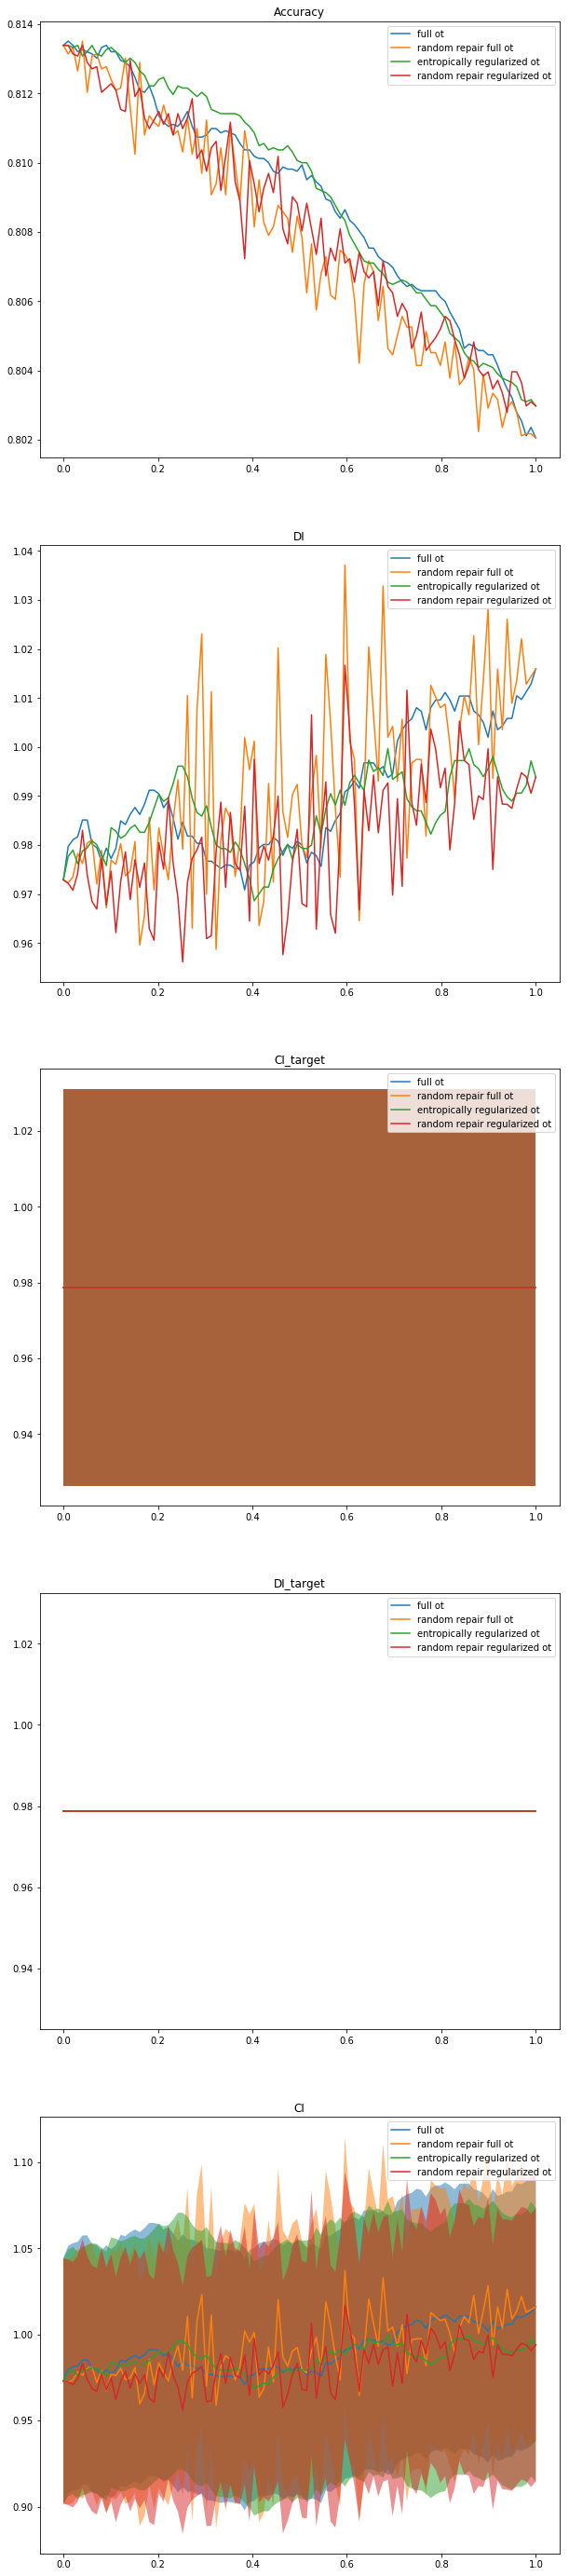

In [43]:
plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4])

### Show that different solutions for the same transporation problem can have different target metric value

### Explore how the regularized barycenters are defined, try to apply them to the problem

### Use the regularized transport maps instead of usual ones